# Procesamiento de Imágenes Digitales

Inteligencia Artificial 2025 II <br>
Examen Parcial, parte práctica de la evaluación **(12 puntos).**

Integrantes:

<font color="blue">Nuñez Poma, Robert Gianpierro Jesus

<font color="blue">Valencia Grey, William Gerardo

## Objetivos


Los objetivos de esta práctica son:
* Repasar algunos conceptos de filtrado de imágenes y programar algunas rutinas para suavizado y extracción de bordes.
* Implementar un algoritmo de segmentación de imágenes
* Aprenderemos sobre detección de bordes, implementaremos nuevas técnicas de thresholding y veremos un ejemplo de MSER.

## Requerimientos

Para esta práctica es necesario disponer del siguiente software:

* Python 3.X
* Jupyter http://jupyter.org/.
* Los paquetes "pip" y  "PyMaxFlow"
* Las librerías científicas de Python: NumPy,  y Matplotlib.
* El paquete PyGame.
* La librería OpenCV.



## Condiciones

* La entrega consiste en dos archivos con el código, resultados y respuestas a los ejercicios:
  1. Un "notebook" de Jupyter con los resultados. Las respuestas a los ejercicios debes introducirlas en tantas celdas de código o texto como creas necesarias, insertadas inmediatamente después de  un enuciado y antes del siguiente.
  2. Un documento "pdf" generado a partir del fuente de Jupyter, por ejemplo usando el comando ``jupyter nbconvert --execute --to pdf notebook.ipynb``, o simplemente imprimiendo el "notebook" desde el navegador en la opción del menú "File->Print preview". Asegúrate de que el documento "pdf" contiene todos los resultados correctamente ejecutados.
* Esta parte de la práctica se realiza en grupos de 2 personas.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
base_path = "/content/drive/MyDrive/PCs_IA/pc2_IA/imagenes/"

# 1. Representación de Imágenes con Filtros

**FUNCIONES PROPORCIONADAS A LOS ESTUDIANTES**

In [107]:
import cv2
import os
import numpy as np
import time
from scipy import ndimage
import matplotlib.pyplot as plt
from ipywidgets import interactive, fixed, widgets
plt.rcParams['figure.figsize'] = (15.0, 15.0)

### FUNCTIONS PROVIDED TO STUDENTS ###
# Filters
def gaussian1d(sigma, mean, x, ord):
    x = np.array(x)
    x_ = x - mean
    var = sigma**2

    # Gaussian Function
    g1 = (1/np.sqrt(2*np.pi*var))*(np.exp((-1*x_*x_)/(2*var)))

    if ord == 0:
        g = g1
        return g
    elif ord == 1:
        g = -g1*((x_)/(var))
        return g
    else:
        g = g1*(((x_*x_) - var)/(var**2))
        return g

def gaussian2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    return g

def log2d(sup, scales):
    var = scales * scales
    shape = (sup,sup)
    n,m = [(i - 1)/2 for i in shape]
    x,y = np.ogrid[-m:m+1,-n:n+1]
    g = (1/np.sqrt(2*np.pi*var))*np.exp( -(x*x + y*y) / (2*var) )
    h = g*((x*x + y*y) - var)/(var**2)
    return h

def makefilter(scale, phasex, phasey, pts, sup):
    gx = gaussian1d(3*scale, 0, pts[0,...], phasex)
    gy = gaussian1d(scale,   0, pts[1,...], phasey)

    image = gx*gy

    image = np.reshape(image,(sup,sup))
    return image

def makeLMfilters():
    sup     = 49
    scalex  = np.sqrt(2) * np.array([1,2,3])
    norient = 6
    nrotinv = 12

    nbar  = len(scalex)*norient
    nedge = len(scalex)*norient
    nf    = nbar+nedge+nrotinv
    F     = np.zeros([sup,sup,nf])
    hsup  = (sup - 1)/2

    x = [np.arange(-hsup,hsup+1)]
    y = [np.arange(-hsup,hsup+1)]

    [x,y] = np.meshgrid(x,y)

    orgpts = [x.flatten(), y.flatten()]
    orgpts = np.array(orgpts)

    count = 0
    for scale in range(len(scalex)):
        for orient in range(norient):
            angle = (np.pi * orient)/norient
            c = np.cos(angle)
            s = np.sin(angle)
            rotpts = [[c+0,-s+0],[s+0,c+0]]
            rotpts = np.array(rotpts)
            rotpts = np.dot(rotpts,orgpts)
            F[:,:,count] = makefilter(scalex[scale], 0, 1, rotpts, sup)
            F[:,:,count+nedge] = makefilter(scalex[scale], 0, 2, rotpts, sup)
            count = count + 1

    count = nbar+nedge
    scales = np.sqrt(2) * np.array([1,2,3,4])

    for i in range(len(scales)):
        F[:,:,count]   = gaussian2d(sup, scales[i])
        count = count + 1

    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, scales[i])
        count = count + 1

    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, 3*scales[i])
        count = count + 1

    for i in range(F.shape[2]):
        F[:,:,i] = np.flip(F[:, :, i], 0 )
    return F


**Ejercicio 1. (3.5 puntos) Representación de Imágenes con Filtros**

En este problema, medirás las respuestas de las imágenes a diferentes filtros. Para cada imagen, calcularás la respuesta de cada píxel a los filtros de un banco de filtros "filter bank". In a later assignment, you will use these responses to filters to compute image representations.

1.  Hay algunas imágenes disponibles: imagenes/cardinal1, imagenes/cardinal2, imagenes/leopard1, imagenes/leopard2, imagenes/panda1, imagenes/panda2.
2. Usa la función makeLMfilters from [the Leung-Malik filter bank](http://www.robots.ox.ac.uk/~vgg/research/texclass/filters.html) , y ejecútala para obtener un conjunto de filtros. Cada filtro F[:, :, i] tiene tamaño 49x49, y hay 48 filtros..
3. En la función filter_responses(), , usa un arreglo para almacenar la lista de nombres de archivo de modo que puedas iterar sobre ellos. Lee todas las imágenes y conviértelas al mismo tamaño cuadrado (p. ej., 100×100), para que el mapa visual de respuestas sea más comparable entre imágenes. Además, convierte las imágenes a escala de grises. Convoluciona cada imagen con cada uno de los 48 filtros usando  [ndimage.convolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html)
4. Para cada filtro, genera una subfigura (subplot) de 2×4 que muestre las siguientes filas: (1) el filtro y una subfigura (subplot) en blanco, (2) las respuestas para las imágenes de “cardinal”, (3) las respuestas para las imágenes de “leopard” y (4) las respuestas para las imágenes de “panda”. Para visualizar la imagen, puedes usar cmap='cividis', y para las respuestas de los filtros, cmap='plasma'.
5. Elige e incluye en tu entrega: (1) un filtro donde las respuestas de imágenes del **mismo** animal sean similares, mientras que las respuestas de imágenes de **animales distintos** sean claramente diferentes. Llama a esta imagen de filtro **filter_1.png**; (2) o un filtro donde las respuestas de diferentes animales se vean bastante similares. Llama a esta imagen de filtro **filter_2.png**. Explica lo que observas en cada caso. Consulta un ejemplo para un filtro a continuación. Tip:  puedes usar  plt.savefig("responses_to_filter_"+str(i+1)+".png"); para guardar tus subplots, e modo que luego puedas examinarlas y elegir ejemplos interesantes. A continuación se muestra un ejemplo de resultados.

![title](https://drive.google.com/uc?export=view&id=1eoCMStSgpFh99OFM37gk19GmScYaRdPp)

**Aquí tu respuesta a la pregunta 5. Recuerda incluir las imágenes en la carpeta submit, y visualízalos en este notebook.**

In [4]:
def filter_responses(filter_num=0, verbose=False):
  """
      Args:
      filter_num: el número de filtro de la lista de filtros que se va a usar
      verbose: Sólo mostrar imágenes si es True

      Returns:
      responses: imagenes filtradas
  """

  image_names = [
    "cardinal1.jpg", "cardinal2.jpg",
    "leopard1.jpg", "leopard2.jpg",
    "panda1.jpg", "panda2.jpg"
  ]

  responses = {}

  filter = makeLMfilters()[:,:,filter_num]

  for image in image_names:
    img = cv2.imread(base_path + image)
    img_resized = cv2.resize(img, (100, 100))
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

    # Aplicar el filtro seleccionado
    response = ndimage.convolve(img_gray, filter, mode='reflect')
    responses[image] = response

  if verbose:
    i=3

    plt.figure(figsize=(10, 5))
    # muestra la imagen inicial
    plt.subplot(2,4,1)
    plt.imshow(filter, cmap='plasma')
    plt.title('Filtro', color='blue')
    plt.axis('off')

    # muestra la imagen resultante
    plt.subplot(2,4,2)
    plt.title('En blanco', color='blue')
    plt.axis('on')
    plt.gca().set_aspect('equal')

    for image in image_names:
      plt.subplot(2,4,i)
      plt.imshow(responses[image], cmap='cividis')
      plt.title(image, color='blue')
      plt.axis('off')
      i+=1

    plt.tight_layout()

    plt.show()

    return

  return responses

In [5]:
# Visualizations of results for Part I
interactive(filter_responses, filter_num=(0, 47, 1), verbose=fixed(True))

interactive(children=(IntSlider(value=0, description='filter_num', max=47), Output()), _dom_classes=('widget-i…

![filtro1](https://drive.google.com/uc?export=view&id=1_EQAcG-baUExbJbCBsTiBVdGVfU25FCP)
![filtro2](https://drive.google.com/uc?export=view&id=1DrEl0ajBdIHMimBFAFS30gCi_kUA9du6)

**Ejercicio 2.** (3 puntos) En las prácticas calificadas 1 y 2 (y en los ejercicios precedentes) hemos trabajado con una sola imagen y sobre ella hemos aplicado nuestros filtros de paso bajo y paso alto. Sin embargo ahora hemos cambiado nuestra cámara de un modo de toma única a una secuencia continua de tomas de imágenes (multi-shot),Se trata de un modo de disparo continuo también llamado modo ráfaga (*burst mode*). Se han obtenido las secuencias autorafaga1_(0:9).jpg y autorafaga2_(0:9).jpg para realizar las pruebas de este apartado.

Las secuencias de imágenes permiten utilizar el promediado de imágenes **image averaging** para eliminar el ruido, la última técnica que vamos a probar. En esta técnica, el contenido de cada píxel en la imagen final es el resultado de promediar el valor de ese píxel en toda la secuencia. Tenga en cuenta que, en el contexto de nuestra aplicación, esta técnica sólo funcionará si el coche está completamente parado.

La idea detrás del promedio de imágenes es que, utilizando un alto número de imágenes ruidosas de una cámara fja en una escena estática, la imagen resultante será libre de ruido. Esto se supone porque algunos tipos de ruido suelen tener media cero. Matemáticamente:

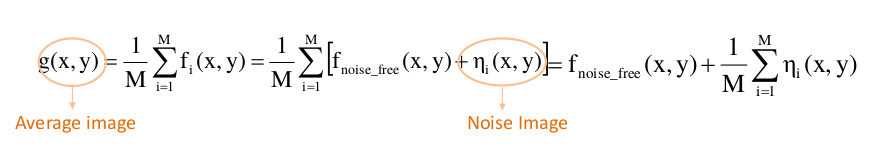

$$
g(x,y) =
\frac{1}{M} \sum_{i=1}^M f_i(x,y) =
\frac{1}{M} \sum_{i=1}^M [f_{\text{noise_free}}(x,y)+n_i(x,y)] = \\
= f_{\text{noise_free}}(x,y) + \frac{1}{M} \sum_{i=1}^M n_i(x,y)
$$

Este método

- es muy eficaz con ruido gaussiano, y
- también preserva los bordes.



Por el contrario:

- no funciona bien con ruido salt&pepper, y
- sólo es aplicable a secuencias de imágenes de una escena fija.




Queremos analizar la idoneidad de este método para nuestra aplicación, así que tienes que completar el método `image_averaging()` method.
Este método toma:
- una secuencia de imágenes estructurada como un array multidimensional [sequence length $\times$ height $\times$ width], y
- el número de imágenes que se van a utilizar.

*Tip: Puedes tomar ideas de aquí: [average of an array along a specified axis](https://docs.scipy.org/doc/numpy-1.9.2/reference/generated/numpy.average.html)

In [6]:
# Implementa una función que:
# -- tome un número de imágenes de la secuencia (burst_length)
# -- promedia el valor de cada pixel en la parte seleccionada de la secuencia
# -- muestra la primera imagen de la secuencia y la final filtrada en un gráfico 1x2 si verbose = True
# -- devuelve la imagen promedio (average image)
def image_averaging(burst, burst_length, verbose=False):
  """ Aplica el promediado de imagenes a una secuencia de imagenes y la muestra.

      Args:
      burst: Matriz 3D que contiene la secuencia de imagenes completa.
      burst_length: Numero natural que indica cuantas imagenes
      se van a utilizar.
      verbose: Sólo mostrar imágenes si es True

      Returns:
      average_img: imagen suavizada
  """

  #Tomar solo imágenes `burst_length`
  burst = burst[0:burst_length]

  # Aplicar el promediado de imágenes
  average_img = np.mean(burst, axis=0)

  # Cambiar el tipo de datos a 8 bits sin signo, como se espera para plt.imshow()
  average_img = average_img.astype(np.uint8)

  if verbose:
    # muestra la imagen inicial
    plt.subplot(1,2,1)
    plt.imshow(burst[0], cmap='gray')
    plt.title('Noisy')
    plt.axis('off')

    # muestra la imagen resultante
    plt.subplot(1,2,2)
    plt.imshow(average_img, cmap='gray')
    plt.title('Image averaging')
    plt.axis('off')

    plt.show()

    return

  return average_img

You can use the next code to **test if your results are correct**:

In [7]:
burst = np.array([[[1,6,2,5],[10,6,22,7],[7,7,13,0],[0,2,8,4]],
                  [[7,7,13,0],[0,2,8,4],[1,6,2,5],[10,6,22,7]],
                  [[7,7,13,0],[0,2,8,4],[1,6,2,5],[10,6,22,7]]],dtype=np.uint8)

print(image_averaging(burst, 2))

[[ 4  6  7  2]
 [ 5  4 15  5]
 [ 4  6  7  2]
 [ 5  4 15  5]]


<font color='blue'>**Expected output:**  </font>

    [[ 4  6  7  2]
     [ 5  4 15  5]
     [ 4  6  7  2]
     [ 5  4 15  5]]

Now check how the number of images used affect the noise removal (play with both sequences):

In [8]:
# Interactua con la duración de la rafaga de imágenes
# leer la secuencia de imagens
burst = []
for i in range(10):
    burst.append(cv2.imread(base_path + 'autorafaga1_' + str(i) + '.jpg', 0))

# cast a el tipo array
burst = np.asarray(burst)

interactive(image_averaging, burst=fixed(burst), burst_length=(1, 10, 1), verbose=fixed(True))

interactive(children=(IntSlider(value=5, description='burst_length', max=10, min=1), Output()), _dom_classes=(…

In [9]:
# Interactua con la duración de la rafaga de imágenes
# leer la secuencia de imagens
burst = []
for i in range(10):
    burst.append(cv2.imread(base_path + 'autorafaga2_' + str(i) + '.jpg', 0))

# cast a el tipo array
burst = np.asarray(burst)

interactive(image_averaging, burst=fixed(burst), burst_length=(1, 10, 1), verbose=fixed(True))

interactive(children=(IntSlider(value=5, description='burst_length', max=10, min=1), Output()), _dom_classes=(…

### <font color="blue"><b><i>Analizando (5)</i></b></font>

**Se te pidió** probar **image_averaging** con las secuencias de imágenes de `autorafaga1_XX.jpg` y `autorafaga2_XX.jpg`. Ahora, **responde estas preguntas**:

- ¿Se logró remover el ruido en ambas secuencias?

    <font color="blue">En la secuencia 1 se logró remover el ruido completamente, mientras que, en la secuencia 2 se pudo remover significativamente el ruido.

- ¿Qué número de fotos debe tomar la cámara en cada secuencia de imágenes?

    <font color="blue">Para la secuencia de imágenes con ruido gaussiano (autorafaga1) se necesitó solo 4 fotos, mientras que para la secuencia con ruido sal y pimienta (autorafaga2) se necesitó de las 10 fotos en total.
- ¿Que otras cosas has observado en este ejercicio? o ¿qué comentarios adicionarías para fortalecer tu explicación?

    <font color="blue"> Recomiendo usar mas fotos para una mayor eliminación de ruido en la secuencia 2.

# 2. Segmentación


## Configuración inicial

##### Importamos librerías

In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import importlib

##### Aumentamos el tamaño de las imágenes

In [11]:
plt.rcParams['figure.dpi'] = 200

In [108]:
plt.rcParams['figure.figsize'] = (3.0, 3.0)

## Parte 1 ·  Detección de bordes (2.5 puntos)

Detectar los bordes de un objeto nos permite visualizarlo de una manera distinta, pudiendo extraer propiedades y características de su estructura.

A continuación trabajaremos con una foto de un tomate. Encontraremos sus bordes usando LoG y Canny.

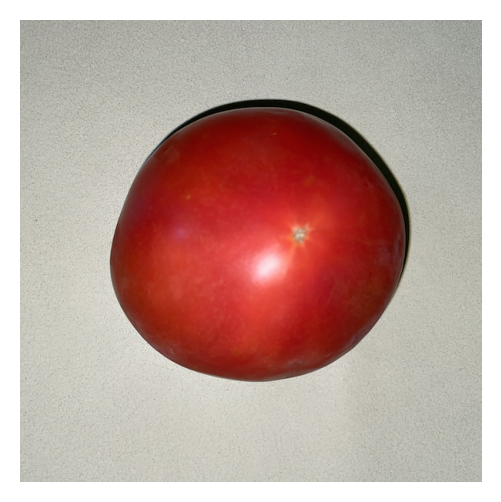

In [109]:
img_tomato_path = base_path + "tomato.png"
img_tomato_color = cv2.imread(img_tomato_path, cv2.IMREAD_COLOR)
img_tomato_gray = cv2.imread(img_tomato_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img_tomato_color[:, :, ::-1], cmap='gray')
plt.axis('off');

El primer paso del algoritmo LoG es aplicarle un filtro Gaussiano a la imagen.

Usa la función ```GaussianBlur``` de OpenCV para suavizar ```img_tomato_gray```. Usa ```sigma``` igual a 2 y ```ksize``` igual a ```(0, 0)``` para que su valor se calcule automáticamente. Guarda el resultado en ```img_tomato_gaussian```.

In [110]:
# Escribe tu código en las siguientes líneas
img_tomato_gaussian = cv2.GaussianBlur(img_tomato_gray, (0, 0), 2)

##### Chequeo

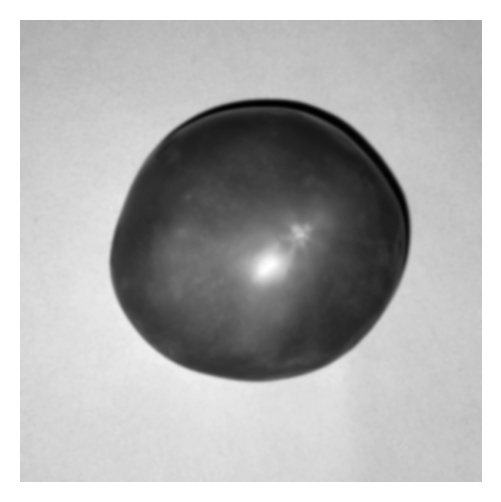

In [111]:
plt.imshow(img_tomato_gaussian, cmap='gray')
plt.axis('off');

Excelente, has filtrado la imagen.

Ahora debemos calcular el Laplaciano de ```img_tomato_gaussian```. Usa la función ```Laplacian``` de OpenCV con ```ddepth``` igual a  ```cv2.CV_16S``` y ```ksize``` igual a 3. Guarda el resultado en ```img_tomato_borders_log```.

In [49]:
# Escribe tu código en las siguientes líneas
img_tomato_borders_log = cv2.Laplacian(img_tomato_gaussian, cv2.CV_16S, ksize=3)


##### Chequeo

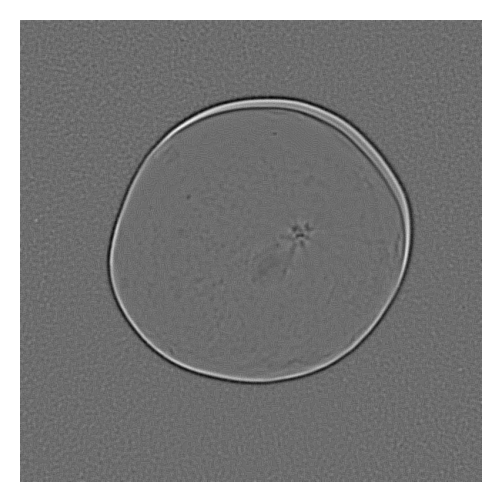

In [112]:
plt.imshow(img_tomato_borders_log, cmap='gray')
plt.axis('off');

Tenemos el Laplaciano del Gaussiano. Vemos que en los bordes del tomate hay cruces por cero con una gran pendiente.

El siguiente paso debería ser encontrar los cruces por cero de ```img_tomato_borders_log```. Sin embargo, debido a la baja complejidad de la foto podemos obtener los bordes de una manera más simple: aplicándole un umbral global.

In [51]:
img_tomato_borders_log_bin = (img_tomato_borders_log > 10).astype(np.uint8)

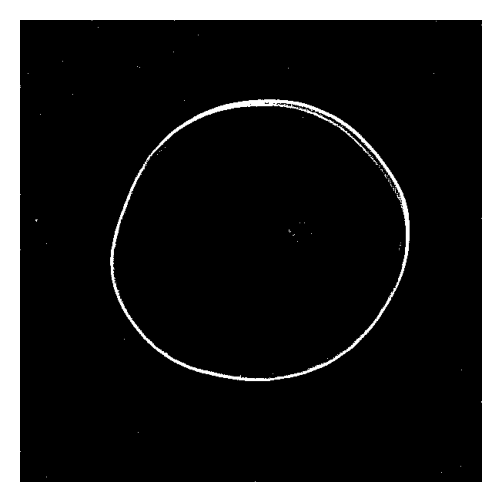

In [113]:
plt.imshow(img_tomato_borders_log_bin, cmap='gray')
plt.axis('off');

Hemos encontrado los bordes del tomate con solo tres líneas de código. El resultado no es perfecto, pero para ciertas aplicaciones es suficientemente bueno. Este se podría mejorar encontrando los cruces por cero en vez de usando un umbral simple.

Veamos cómo quedan los bordes al aplicar el algoritmo de Canny. Comenzando con ```img_tomato_gray```, aplica la función ```Canny``` de OpenCV con los umbrales 200 y 600. Guarda el resultado en ```img_tomato_borders_canny```.

In [53]:
# Escribe tu código en las siguientes líneas
img_tomato_borders_canny = cv2.Canny(img_tomato_gray, 200, 600)


##### Chequeo

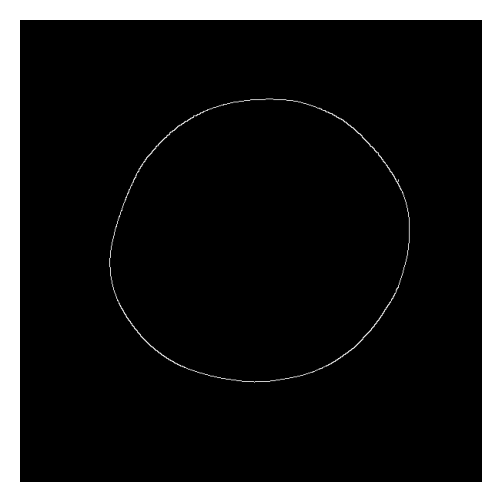

In [114]:
plt.imshow(img_tomato_borders_canny, cmap='gray')
plt.axis('off');

El resultado usando Canny y los parámetros escogidos es perfecto. Obtuvimos una imagen binaria donde el borde es representado como una línea contínua de ancho unitario.

Ahora que tenemos el borde del objeto podemos aplicarle un algoritmo de _region growing_ para obtener toda su región.

In [115]:
import cv2
import scipy.ndimage

def region_growing(img, seed_coords):
    mask = np.zeros(img.shape)
    mask[seed_coords] = 1
    old_mask = np.zeros(img.shape, dtype=np.uint8)
    while not np.array_equal(old_mask, mask):
        old_mask = mask.copy()
        mask = scipy.ndimage.binary_dilation(mask)
        mask = np.logical_and(mask, np.logical_not(img))
    mask = mask.astype(np.uint8)
    return mask

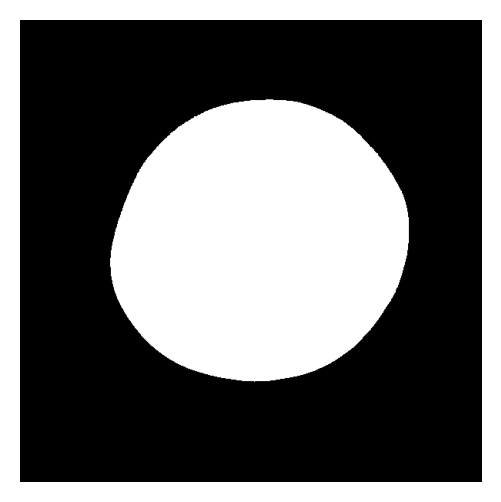

In [116]:
mask_tomato_canny = region_growing(img_tomato_borders_canny, (300, 300))

plt.imshow(mask_tomato_canny, cmap='gray')
plt.axis('off');

La máscara obtenida es perfecta. Ahora la podemos usar para segmentar el objeto de interés.

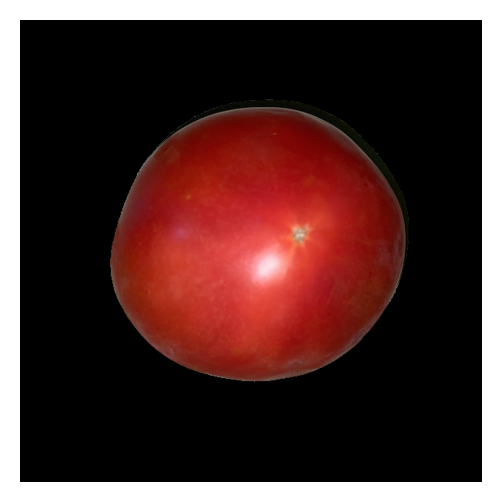

In [117]:
img_tomato_masked = cv2.bitwise_and(img_tomato_color, img_tomato_color, mask=mask_tomato_canny)

plt.subplot(1, 1, 1)
plt.imshow(img_tomato_masked[:, :, ::-1])
plt.axis('off');

¡Logramos segmentar el tomate a partir de sus bordes!

## Parte 2 ·  Thresholding (3 puntos)

Estudiamos su histograma y definimos un umbral a mano. Veamos si podemos automatizar esta selección de umbral con una fotografía de un avión.

In [ ]:
img_plane_path = './imagenes/plane.jpg'
img_plane_gray = cv2.imread(img_plane_path, cv2.IMREAD_GRAYSCALE)

In [72]:
img_plane_path = base_path + 'plane.jpg'
img_plane_gray = cv2.imread(img_plane_path, cv2.IMREAD_GRAYSCALE)

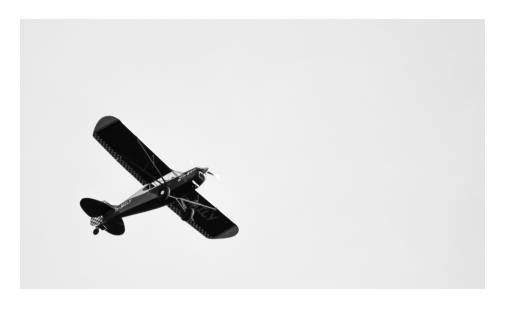

In [118]:
plt.imshow(img_plane_gray, cmap='gray')
plt.axis('off');

En clases vimos que el método de Otsu nos permite encontrar automáticamente el umbral de una imagen cuyo histograma es bimodal. Veamos cómo funciona para esta foto.

Usa la función ```threshold``` de OpenCV para segmentar ```img_plane_gray``` con el método de Otsu. Los pixeles del avión deben valer 0 y el resto 255. Guarda el umbral encontrado en ```thresh_plane_otsu``` y la imagen resultante en ```mask_plane_otsu```.

In [74]:
# Escribe tu código en las siguientes líneas
thresh_plane_otsu, mask_plane_otsu = cv2.threshold(img_plane_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

##### Chequeo

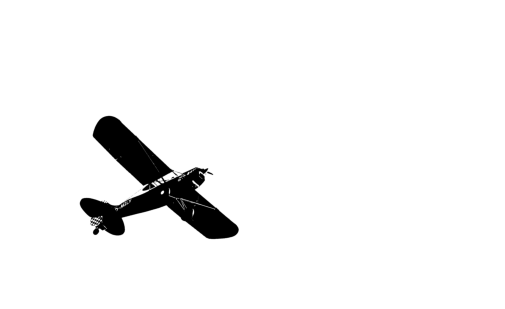

In [119]:
plt.imshow(mask_plane_otsu, cmap='gray')
plt.axis('off');

El umbral encontrado automáticamente logra extraer el avión de la imagen a la perfección.

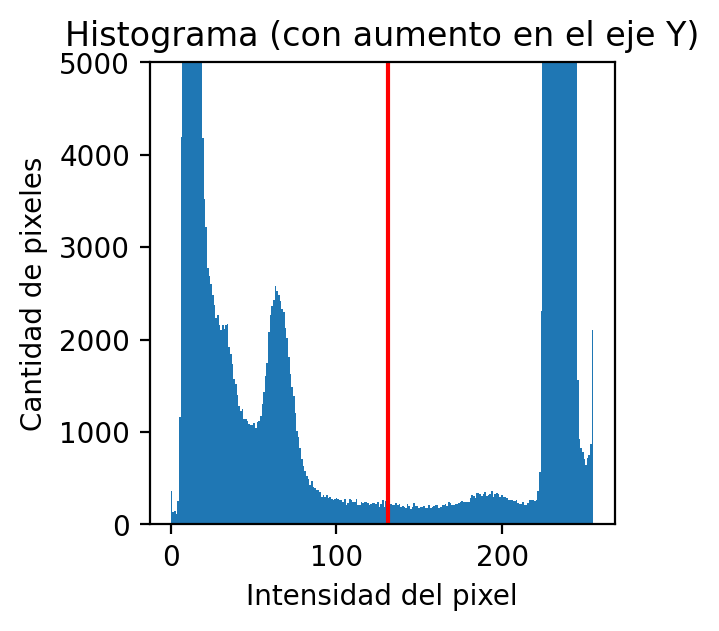

In [120]:
plt.hist(img_plane_gray.ravel(), 256)
plt.axvline(x=thresh_plane_otsu, color='red')
plt.ylim(0, 5000)
plt.title('Histograma (con aumento en el eje Y)')
plt.xlabel('Intensidad del pixel')
plt.ylabel('Cantidad de pixeles');

El método de Otsu calculó un umbral ideal entre los dos grandes _peaks_ que presenta el histograma. Este método es de gran utilidad cuando se debe encontrar el _threshold_ de varias imágenes.

### _Thresholding_ adaptativo

Existen situaciones donde un _threshold_ global no basta para segmentar adecuadamente una imagen. Por ejemplo, veamos la siguente foto de una carta.

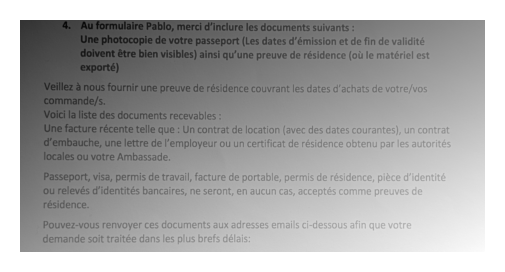

In [121]:
img_text_path = base_path + 'text.png'
img_text = cv2.imread(img_text_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(img_text, cmap='gray')
plt.axis('off');

La foto fue tomada con una iluminación no ideal, por lo que quedó con un gradiente sobre el texto.

Veamos qué pasa si le aplicamos un umbral global. Define ```img_text_thresh_global```, una imagen binaria que segmenta a ```img_text```, fijando en 1 a todos los valores mayores a 100 y en 0 al resto.

In [122]:
# Escribe tu código en las siguientes líneas
_, img_text_thresh_global = cv2.threshold(img_text, 100, 1, cv2.THRESH_BINARY)

##### Chequeo

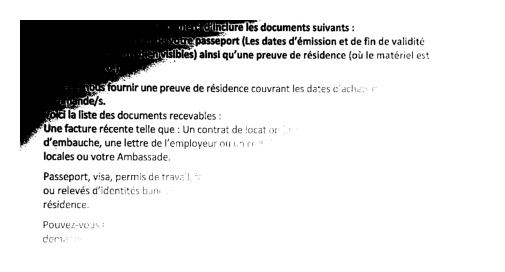

In [123]:
plt.imshow(img_text_thresh_global, cmap='gray')
plt.axis('off');

Claramente, un umbral global no permite segmentar adecuadamente el texto. Probemos algo distinto.

Como el tono de gris promedio no es el mismo en distintas secciones de la imagen, una solución consiste en usar un algoritmo que aplique umbrales locales para bloques pequeños de la imagen.

Crea la función ```adaptive_threshold_otsu(img, block_size, constant)``` que segmente adaptativamente una imagen. La función tomará ```img``` y la dividirá en bloques de ```block_size``` x ```block_size```. Luego iterará sobre cada uno de estos bloques y calculará el _threshold_ óptimo con el método de Otsu. El umbral a aplicar en cada bloque debe ser ```constant``` menor al retornado por Otsu. El texto debe valer 0 y el papel 1. La imagen final debe ser la concatenación de cada uno de los bloques.

In [124]:
# Escribe tu código en las siguientes líneas
def adaptive_threshold_otsu(img, block_size, constant):
    h, w = img.shape

    output_img = np.zeros_like(img, dtype=np.uint8)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):

            y_end = min(i + block_size, h)
            x_end = min(j + block_size, w)

            block = img[i:y_end, j:x_end]

            if block.size == 0:
                continue

            otsu_thresh, _ = cv2.threshold(block, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            adaptive_thresh = otsu_thresh - constant

            _, block_thresh = cv2.threshold(block, adaptive_thresh, 1, cv2.THRESH_BINARY)

            output_img[i:y_end, j:x_end] = block_thresh

    return output_img

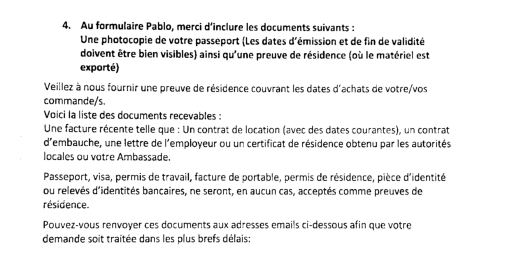

In [125]:
img_text_thresh_adaptive = adaptive_threshold_otsu(img_text, 60, 10)
plt.imshow(img_text_thresh_adaptive, cmap='gray')
plt.axis('off');

##### Chequeo

Como el algoritmo calcula un umbral óptimo para cada bloque, obtenemos una imagen segmentada adecuadamente.

También podemos aplicar un _thresholding_ adaptativo usando funciones de OpenCV. Segmenta ```img_text``` usando la función ```adaptiveThreshold``` de OpenCV en el modo media, con un tamaño de bloque igual a 61 y una constante igual a 10. Ahora, el texto debe valer 0 y el papel 255. Guarda el resultado en ```img_text_thresh_mean```.

[Aquí](https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html) se muestra cómo usar la función.

In [90]:
# Escribe tu código en las siguientes líneas
img_text_thresh_mean = cv2.adaptiveThreshold(img_text, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 61, 10)


##### Chequeo

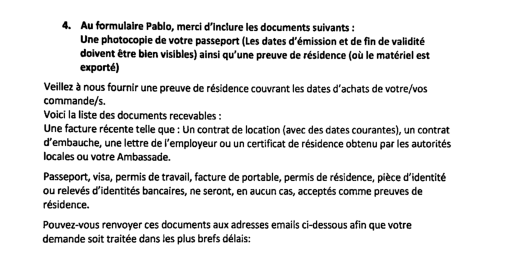

In [126]:
plt.imshow(img_text_thresh_mean, cmap='gray')
plt.axis('off');

Al igual que con la función que creaste anteriormente, se obtienen fantásticos resultados.

Probemos haciendo lo mismo pero con el modo Gaussiano. Usa los mismos parámetros que antes y guarda el resultado en ```img_text_thresh_gaussian```.

In [92]:
# Escribe tu código en las siguientes líneas
img_text_thresh_gaussian = cv2.adaptiveThreshold(img_text, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 61, 10)


##### Chequeo

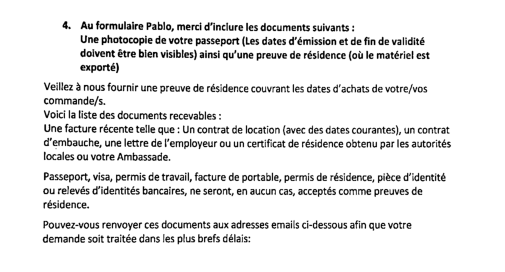

In [127]:
plt.imshow(img_text_thresh_gaussian, cmap='gray')
plt.axis('off');

Nuevamente obtenemos excelentes resultados. ¡Felicitaciones!

## Parte 3 · MSER

Existen casos donde queremos segmentar varios objetos de una imagen que tienen tonos de grises distintos. Por ejemplo, tomemos la siguiente foto:



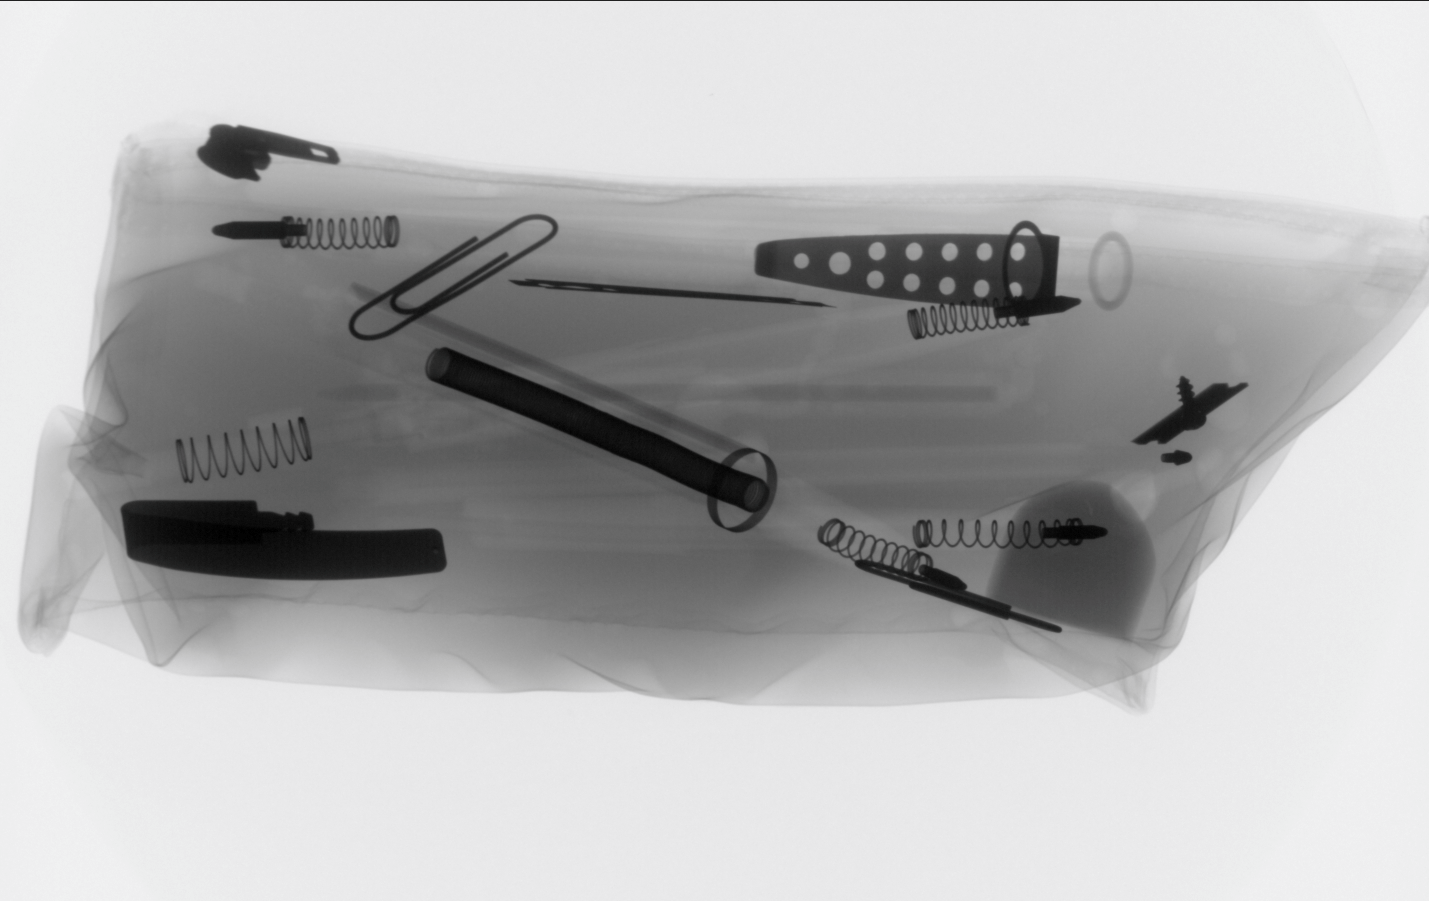

Debido a los distintos tonos de gris, los algoritmos de segmentación vistos probablemente no lograrían segmentar los objetos correctamente.

Para casos como este podemos usar el algoritmo MSER. Este nos permite identificar y segmentar los objetos individualmente, obteniendo los _bounding box_ de cada uno.

El siguiente ejemplo usa OpenCV para encontrar las regiones y los _bounding boxes_ de cada uno de los objetos. Luego se etiqueta cada objeto y se calculan sus bordes.

In [ ]:
# Importamos las librerías de skimage necesarias
import skimage.measure
import skimage.morphology
import skimage.segmentation

# Cargamos la radiografía del estuche
img_pencilcase_path = './imagenes/pencilcase.png'
img_pencilcase = cv2.imread(img_pencilcase_path, cv2.IMREAD_GRAYSCALE)

# Creamos nuestro detector MSER
mser = cv2.MSER_create(
    min_area=60,
    max_area=40000,
    min_diversity=0.9,
    max_variation=0.2,
    delta=3
)

# Detectamos las regiones
regions, bbox = mser.detectRegions(img_pencilcase)

# Creamos una máscara con las regiones detectadas
mask_pencilcase = np.zeros(img_pencilcase.shape)
for _, region in enumerate(regions):
    mask_pencilcase[region[:,1], region[:,0]] = 1

# Identificamos y etiquetamos los objetos individuales
label_regions = skimage.measure.label(mask_pencilcase, connectivity=1)

# Convertimos el formato de los bounding boxes
props = skimage.measure.regionprops(label_regions)
bboxes = np.array([[p.bbox[1], p.bbox[0],
                    p.bbox[3] - p.bbox[1], p.bbox[2] - p.bbox[0]]
                   for p in props])

# Encontramos los bordes de los objetos
edges = skimage.morphology.binary_dilation(
    skimage.segmentation.find_boundaries(
        mask_pencilcase, connectivity=1, mode='inner'), np.ones((3, 3)))

In [94]:
# Importamos las librerías de skimage necesarias
import skimage.measure
import skimage.morphology
import skimage.segmentation

# Cargamos la radiografía del estuche
img_pencilcase_path = base_path + 'pencilcase.png'
img_pencilcase = cv2.imread(img_pencilcase_path, cv2.IMREAD_GRAYSCALE)

# Creamos nuestro detector MSER
mser = cv2.MSER_create(
    min_area=60,
    max_area=40000,
    min_diversity=0.9,
    max_variation=0.2,
    delta=3
)

# Detectamos las regiones
regions, bbox = mser.detectRegions(img_pencilcase)

# Creamos una máscara con las regiones detectadas
mask_pencilcase = np.zeros(img_pencilcase.shape)
for _, region in enumerate(regions):
    mask_pencilcase[region[:,1], region[:,0]] = 1

# Identificamos y etiquetamos los objetos individuales
label_regions = skimage.measure.label(mask_pencilcase, connectivity=1)

# Convertimos el formato de los bounding boxes
props = skimage.measure.regionprops(label_regions)
bboxes = np.array([[p.bbox[1], p.bbox[0],
                    p.bbox[3] - p.bbox[1], p.bbox[2] - p.bbox[0]]
                   for p in props])

# Encontramos los bordes de los objetos
edges = skimage.morphology.binary_dilation(
    skimage.segmentation.find_boundaries(
        mask_pencilcase, connectivity=1, mode='inner'), np.ones((3, 3)))

In [133]:
plt.rcParams['figure.figsize'] = (5.0, 4.0)

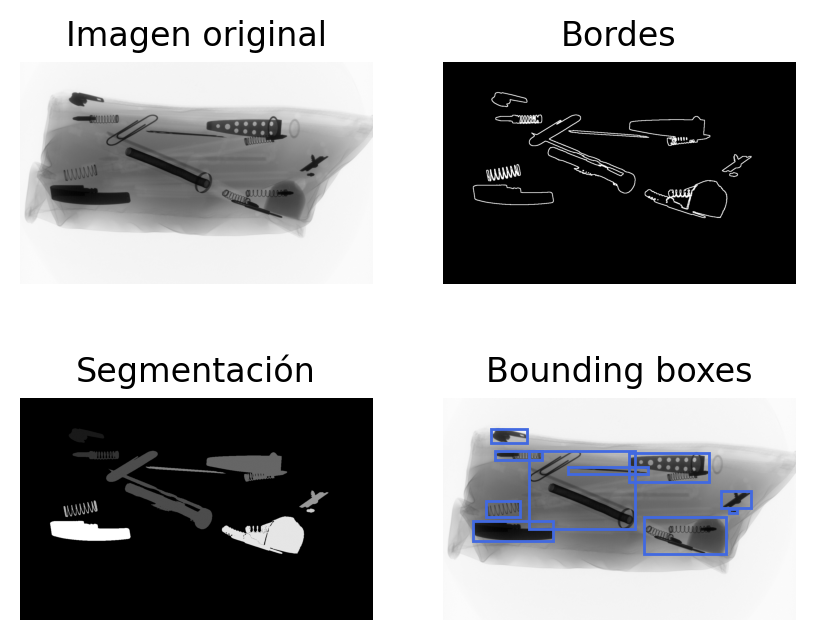

In [134]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(img_pencilcase, cmap='gray')
axs[0, 0].set_title('Imagen original')
axs[0, 0].axis('off')

axs[0, 1].imshow(edges, cmap='gray')
axs[0, 1].set_title('Bordes')
axs[0, 1].axis('off')

axs[1, 0].imshow(label_regions, cmap='gray')
axs[1, 0].set_title('Segmentación')
axs[1, 0].axis('off')

axs[1, 1].imshow(img_pencilcase, cmap='gray')
for b, bbox in enumerate(bboxes):
    rect = plt.Rectangle((bbox[0], bbox[1]),
                         bbox[2], bbox[3],
                         fill=False, edgecolor='royalblue')
    axs[1, 1].add_patch(rect)
axs[1, 1].set_title('Bounding boxes')
axs[1, 1].axis('off');

El algoritmo encontró 10 objetos distintos, segmentándolos bastante bien. El único problema pareciera ser que algunos objetos quedaron juntos pero esto puede ser arreglado con un procesamiento posterior. Logramos obtener los bordes de cada objeto, identificarlos individualmente y obtener sus _bounding boxes_.

¡Puedes probar este código con otras fotos!